# Classical Approximate Bayesian Compuation

In [1]:
import hypothesis
import matplotlib.pyplot as plt
import torch

As in every Bayesian inference setting we have to define a prior $p(\theta)$, which is in our case $\mathcal{U}(-10, 10)$.

In [2]:
from torch.distributions.uniform import Uniform

prior = Uniform(-10, 10)

The simulation-based or likelihood-free setting also requires the definition of a forward model.

In [3]:
from hypothesis.simulation import Simulator

class NormalSimulator(Simulator):
    
    def __init__(self):
        super(NormalSimulator, self).__init__()
        
    def forward(self, inputs):
        inputs = inputs.view(-1, 1)

        return torch.randn(inputs.size(0), 1) + inputs

simulator = NormalSimulator()

Let's check how the joint $p(\theta,x)$ looks like.

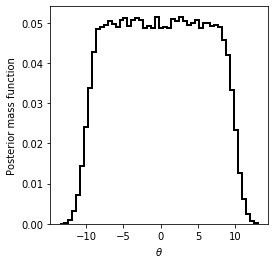

In [4]:
from hypothesis.visualization.util import make_square

n = torch.Size([100000])
inputs = prior.sample(n)
outputs = simulator(inputs)

plt.hist(outputs.numpy(), bins=50, density=True, color="black", histtype="step", lw=2)
plt.xlabel(r"$\theta$")
plt.ylabel("Posterior mass function")
make_square(plt.gca())
plt.show()

Every Bayesian setting requires an observation $x$ (or a set of observations) to compute the posterior of:

In [5]:
truth = prior.sample()
observation = simulator(truth)

print("Observation:", observation.item())

Observation: 5.455133438110352


And finally the posterior sampling procedure itself. The `acceptor` method takes two summary statistics (the observation and the sample being tested), and determines whether or not to accept the sample that has been used to generate `b`.

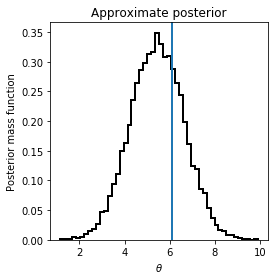

CPU times: user 4.67 s, sys: 136 ms, total: 4.81 s
Wall time: 4.58 s


In [6]:
%%time

from hypothesis.inference.abc import ApproximateBayesianComputation as ABC

def acceptor(a, b, epsilon=1):
    return (a - b).abs().item() < epsilon

def plot_posterior(posterior_samples):
    plt.title("Approximate posterior")
    plt.hist(posterior_samples.numpy(), bins=50, color="black", histtype="step", density=True, lw=2)
    plt.xlabel(r"$\theta$")
    plt.ylabel("Posterior mass function")
    plt.axvline(truth, c="C0", lw=2)
    make_square(plt.gca())
    plt.show()

# Use the identity function as a summary statistic.
def identity(x):
    return x
    
# Allocate the inference procedure.
abc = ABC(simulator=simulator,
    prior=prior,
    summary=identity,
    acceptor=acceptor)

# Sample the approximate posterior. We don't want gradients here (but you can).
with torch.no_grad():
    posterior_samples = abc.sample(observation, num_samples=10000)
    
# Plot the approximate posterior.
plot_posterior(posterior_samples)

Let's check what the effect of a smaller `epsilon` value is in the acceptor method. This might take a bit longer.

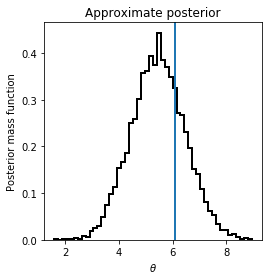

CPU times: user 1min 19s, sys: 160 ms, total: 1min 20s
Wall time: 1min 19s


In [7]:
%%time

def acceptor(a, b, epsilon=0.05):
    return (a - b).abs().item() < epsilon

# Allocate the inference procedure with the new acceptor function.
abc = ABC(simulator=simulator,
    prior=prior,
    summary=identity, 
    acceptor=acceptor)

# Sample the approximate posterior. We don't want gradients here (but you can).
with torch.no_grad():
    posterior_samples = abc.sample(observation, num_samples=10000)
    
# Plot the approximate posterior.
plot_posterior(posterior_samples)

The `ABC` procedure typically uses a single thread to sample from the posterior. However, the sampler can easily be parallelized.

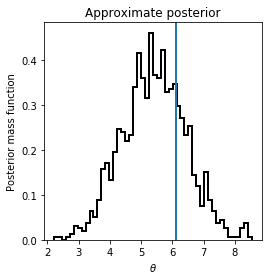

CPU times: user 558 ms, sys: 673 ms, total: 1.23 s
Wall time: 23.8 s


In [8]:
%%time

from hypothesis.inference.abc import ParallelApproximateBayesianComputation as ParallelABC

# Allocate the parallel ABC sampler.
parallel_abc_sampler = ParallelABC(abc, workers=8)

# Sample the approximate posterior. We don't want gradients here (but you can).
with torch.no_grad():
    posterior_samples = parallel_abc_sampler.sample(observation, num_samples=10000)
    
# Plot the approximate posterior.
plot_posterior(posterior_samples)

Done!